<h1><center><font size="6">LANL Earthquake EDA and Prediction</font></center></h1>

<h2><center><font size="4">Dataset used: LANL Earthquake Prediction</font></center></h2>

<img src="https://storage.googleapis.com/kaggle-media/competitions/LANL/nik-shuliahin-585307-unsplash.jpg" width="600"></img>

<br>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Model</a>
- <a href='#6'>Submission</a>  
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  

## Simulated earthquake experiment

The data are from an experiment conducted on rock in a double direct shear geometry subjected to bi-axial loading, a classic laboratory earthquake model.

Two fault gouge layers are sheared simultaneously while subjected to a constant normal load and a prescribed shear velocity. The laboratory faults fail in repetitive cycles of stick and slip that is meant to mimic the cycle of loading and failure on tectonic faults. While the experiment is considerably simpler than a fault in Earth, it shares many physical characteristics. 

Los Alamos' initial work showed that the prediction of laboratory earthquakes from continuous seismic data is possible in the case of quasi-periodic laboratory seismic cycles.   

## Competition 

In this competition, the team has provided a much more challenging dataset with considerably more aperiodic earthquake failures.  
Objective of the competition is to predict the failures for each test set.  

## Kernel

This solution uses  Andrew's Data Munging plus some inspiration from Scirpus's [Kernel](https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model/).



# <a id='1'>Prepare the data analysis</a>

## Load packages

Here we define the packages for data manipulation, feature engineering and model training.

In [1]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

## Load the data

Let's see first what files we have in input directory.

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/LANL/"
else:
    PATH="../input/"
os.listdir(PATH)

['test', 'sample_submission.csv', 'train.csv']

We have two files in the **input** directory and another directory, with the **test** data.  

Let's see how many files are in **test** folder.

In [3]:
print("There are {} files in test folder".format(len(os.listdir(os.path.join(PATH, 'test' )))))

There are 2624 files in test folder




Let's load the train file.

In [4]:
%%time
train_df = pd.read_csv(os.path.join(PATH,'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 20s, sys: 14.1 s, total: 2min 34s
Wall time: 2min 35s


Let's check the data imported.

In [5]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


In [6]:
pd.options.display.precision = 15
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


# <a id='3'>Data exploration</a>  

The dimmension of the data is quite large, in excess of 600 millions rows of data.  
The two columns in the train dataset have the following meaning:   
*  accoustic_data: is the accoustic signal measured in the laboratory experiment;  
* time to failure: this gives the time until a failure will occurs.

Let's plot 1% of the data. For this we will sample every 100 points of data.  

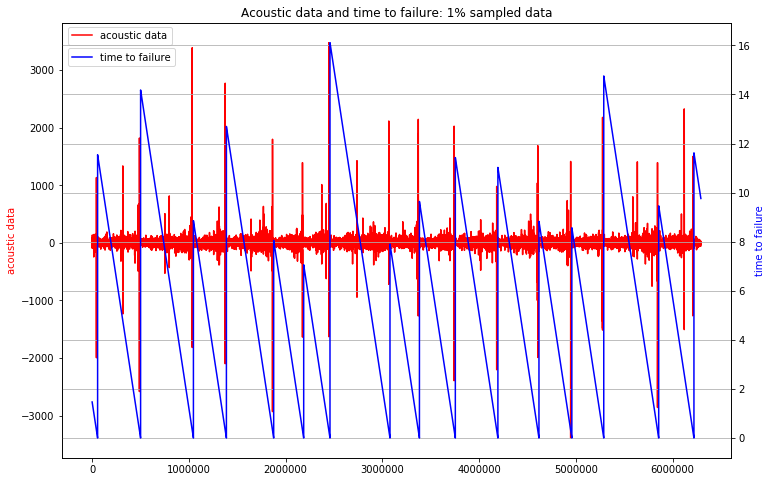

In [7]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

The plot shows only 1% of the full data. 
The acoustic data shows complex oscilations with variable amplitude. Just before each failure there is an increase in the amplitude of the acoustic data. We see that large amplitudes are also obtained at different moments in time (for example about the mid-time between two succesive failures).  

Let's plot as well the first 1% of the data.

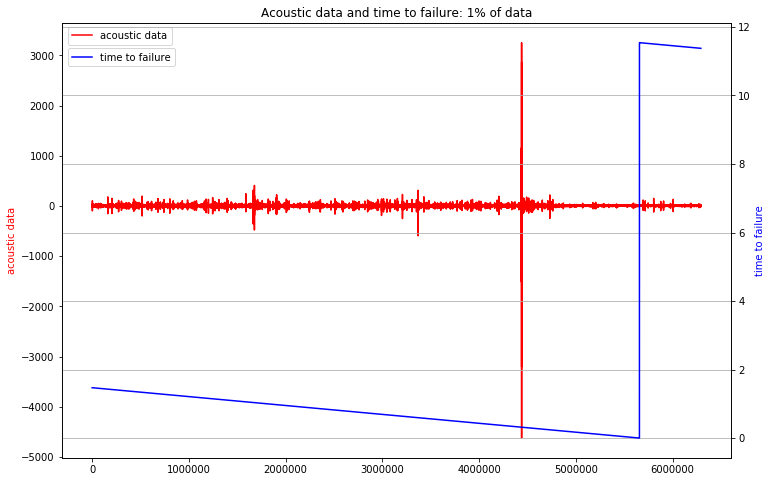

In [8]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

On this zoomed-in-time plot we can see that actually the large oscilation before the failure is not quite in the last moment. There are also trains of intense oscilations preceeding the large one and also some oscilations with smaller peaks after the large one. Then, after some minor oscilations, the failure occurs.

# <a id='4'>Features engineering</a>  

The test segments are 150,000 each.   
We split the train data in segments of the same dimmension with the test sets.

We will create additional aggregation features, calculated on the segments. 


In [9]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


Let's define some computation helper functions.

In [10]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

## Process train file

Now let's calculate the aggregated functions for train set.

In [11]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

In [12]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [13]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

Let's check the result. We plot the shape and the head of train_X.

In [14]:
train_X.shape

(4194, 154)

In [15]:
train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,Rmean_last_5000,Rstd__last_5000,Rmax_last_5000,Rmin_last_5000,Rmean_last_15000,Rstd_last_15000,Rmax_last_15000,Rmin_last_15000,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,...,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113333333334,5.101106130606765,104.0,-98.0,12.000000000000004,2349.811481800189085,732617.0,-20121.154171234855312,-1.067140450080236e-15,1399.854635310395224,23432.719432718040480,-23432.719432718044118,-2.606182613213170,1513.574807585783219,9208.972085564804729,-12837.254225910464811,5.354098198492068,2812.202696607881990,21205.810957063822570,-20121.154171234855312,-0.000080000533337,74836.577199220613693,104.0,0.0,6.488551888989741,3.664663420228340,11.207151110947080,4.361406519310332,4.96210,4.62046,5.1820,4.6756,-98.0,-21.0,-98.0,-16.0,104.0,30.0,104.0,26.0,...,2.302633538390867,2.475638882952861,8.195903140156636,16.948796924021416,-0.000005235445272,74759.569448178153834,52.335254741797996,4.883863549942963,0.452293846429352,10.039999999999999,1.040000000000000,3.81,4.16,5.58,5.95,-0.000002401601067,74760.051283355249325,10.039999999999999,4.288590310584312,2.769772407044410,31.029445007242035,2.536632710012617,2.616094025058814,2.706473905472144,8.185756324653649,15.055998242663405,-0.000011795500483,74223.575745018068119,31.029445007242035,4.883418265649225,0.295714650592636,5.629,3.896,4.072,4.379,5.338,5.484,-0.000001704697987,74222.343442640820285,5.629
1,4.725766666666667,6.588823781946801,181.0,-154.0,4.999999999999998,2566.032248433366476,708865.0,-31056.675076437579264,7.033425693710645e-16,1810.312265881220810,27236.180586073751329,-27236.180586073754966,-0.199454239122083,2551.400329629872431,11606.563754897386389,-11771.116138276469428,9.627270104536805,3786.205511080561791,28750.538465475812700,-31056.675076437579264,0.000000000000000,74891.736231905975728,181.0,0.0,7.305232697765033,5.493070500263983,3.976750132226240,3.667890126734739,4.69840,4.78834,4.7772,4.9144,-154.0,-115.0,-23.0,-24.0,181.0,111.0,29.0,29.0,...,2.300285445615412,2.475965274474054,9.829922366802840,23.457270415662862,-0.000000487196303,74801.961652516256436,87.972617410995625,4.725623311385514,0.496219791758936,16.670000000000002,-4.090000000000000,3.64,4.05,5.39,5.75,-0.000000733822548,74800.114701938757207,16.670000000000002,4.843485536157157,4.492905296027906,38.643217286378224,2.509452799586506,2.612481781957736,2.674879245681564,10.544981537946606,33.704331798479267,-0.000000230972610,74363.664079629437765,38.643217286378224,4.724876383379978,0.231586699576737,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002449664430,74364.426477527638781,5.667
2,4.906393333333333,6.967397033524431,140.0,-106.0,5.000000000000000,2683.549049300198476,735959.0,-27654.557067499525147,-1.261165986458461e-15,1921.220575571685686,30073.497066171181359,-30073.497066171177721,45.078552149036327,2832.190519067848072,16806.749666036223061,-15992.574637120493207,-4

We scale the data.

In [16]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

Let's check the obtained dataframe.

In [17]:
scaled_train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,Rmean_last_5000,Rstd__last_5000,Rmax_last_5000,Rmin_last_5000,Rmean_last_15000,Rstd_last_15000,Rmax_last_15000,Rmin_last_15000,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,...,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140499795022,-0.170213582943171,-0.218193508692627,0.193218185209325,1.199316205489370,-0.105006593381723,1.424140499795018,0.156736086729651,-0.458569665722214,-0.169052005333305,-0.085418851262480,0.085418851262480,-0.050936404418685,-0.191893434486743,-0.205689174753945,0.051904172873359,0.234332512255065,-0.171668764049947,-0.117546225637657,0.156736086729651,-1.326419602086939,-1.569265388202209,-0.222566817896606,0.0,0.052067120339060,-0.285578802588458,0.724222502558045,-0.192422289131222,1.601860964570222,0.367221814954237,2.169233854080213,0.502224097821339,-0.042512812131692,0.465851266004560,-0.563305603256716,0.406807139367380,0.011906885509013,-0.400167192506485,0.718611566927431,-0.453669501370655,...,0.087853413446364,0.138029732281966,-0.252852685374475,-0.188298242736643,-0.125615527396727,-1.418308558720421,-0.185995782509011,1.423147948566635,-0.098603707928001,-0.153539338096965,0.241430974472694,0.305729911776530,1.053726901490764,1.245910025793121,0.155663581395325,-0.487148812090391,-1.392180673751812,-0.153194060702137,-0.164638541689780,-0.187411091061462,-0.112162637649477,0.286995369758164,0.102309155075123,0.184598562852899,-0.431604967494606,-0.208501591842877,-0.296462070562089,-1.823621636308043,-0.112162637649477,1.421035888835048,0.268470130890001,-0.004741890462161,0.178277723969481,0.287332145975991,0.965402446610929,1.509153430549683,0.885262121712506,-0.631300343511894,-1.832422175860377,-0.004741890462161
1,0.805716032556442,0.004734017014316,0.063936007992510,-0.018037271219829,0.078885810556771,-0.008598597346281,0.805716032556438,-0.222117948425052,0.286704970489610,0.007211752080005,0.042859402850455,-0.042859402850455,0.002524873711621,0.004038730816301,-0.105218548017268,0.097303239240435,0.421938151420475,0.014326298054843,0.137447930663486,-0.222117948425052,0.002746647790241,-1.040205647784611,0.036796505974809,0.0,0.153858292399954,-0.076987041316589,-0.195868738188691,-0.310469522417300,0.648208828305486,0.978584560671578,0.845957983265294,1.270319586552552,-0.384877683496999,-0.140002032705829,0.197633772937809,0.282558653740508,0.541182287093263,0.026976730006776,-0.316480514514776,-0.401697638798994,...,0.053417972994497,0.141753370745496,0.031137820903566,-0.043328460600485,-0.015100677004593,-1.107456607734533,0.086114276234639,0.805142080825855,-0.046104445698584,0.115950605224415,0.005951234004558,0.198170261083282,0.697866713260562,0.621246096190321,0.022996834723512,-0.137007577024700,-1.097764806669497,0.112852278731699,0.087107955335462,0.017980985665859,-0.022922754493189,-0.143446237150871,0.050643768810226,-0.151081703768459,-0.048381866760125,0.148106129060709,-0.0036885

## Process test data

We apply the same processing done for the training data to the test data.

We read the submission file and prepare the test file.

In [18]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

Let's check the shape of the submission and test_X datasets.

In [19]:
submission.shape, test_X.shape

((2624, 1), (2624, 154))

In [20]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)

We scale also the test data.

In [21]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [22]:
scaled_test_X.shape

(2624, 154)

In [23]:
scaled_test_X.tail(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,Rmean_last_5000,Rstd__last_5000,Rmax_last_5000,Rmin_last_5000,Rmean_last_15000,Rstd_last_15000,Rmax_last_15000,Rmin_last_15000,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,...,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2614,-1.081634623438432,-0.268601942297170,-0.350098217792172,0.329025264342352,-0.081175674433600,-0.256057804503499,-1.081634623438434,0.296094951842351,-0.213547867515587,-0.265116961140863,-0.201472659457148,0.201472659457148,-0.033419234524520,-0.230068916798155,-0.361763311619542,0.186730178774563,0.218934628017159,-0.286420231743312,-0.353216303669750,0.296094951842351,0.556565918572399,0.067458152169156,-0.343827592693630,0.0,-0.194797775810135,-0.181187014366608,0.226688098234780,-0.358904125895162,-1.104963271119692,-0.949822803917177,-0.648611503238114,-1.502286407108699,0.195919866140574,0.201596103801092,-0.167617127635563,0.251496532333791,-0.263041375054234,-0.199778685648412,0.166562456824921,-0.315077867846225,...,-0.491934690664684,-0.277210146213758,-0.436395660964741,-0.250740979654654,-0.024851657132586,-0.453592458252900,-0.331374909243024,-1.082343457235757,-0.158108154173992,-0.190528153846959,0.247398297330561,0.014686151077152,-0.660872187254751,-0.923975203353446,-0.288770019955249,-0.431126214479880,-0.459280128005422,-0.189710224938154,-0.392402593573372,-0.286992366591841,-0.289327881394294,-0.202973173143082,-0.282951251226404,-0.177162079550320,-0.587486627475120,-0.239649531659756,-0.951804747883167,-0.333430994719307,-0.289327881394294,-1.078573138003365,-0.131863367972886,-0.197756385756125,0.067608697543058,-0.245432983826332,-0.755380587355362,-0.834320554361995,-0.568229086274198,-0.621183095678739,-0.332742633283314,-0.197756385756125
2615,-0.734695164615844,-0.320940103313106,-0.390402434461477,0.400701222773672,0.559070265527884,-0.271490841421192,-0.734695164615847,0.457524666141680,-0.264594075475301,-0.320648190853422,-0.465674449813843,0.465674449813843,-0.854972771535990,-0.269256128178346,-0.354430000005880,0.384782114685467,-0.546622737334748,-0.341881207583895,-0.457367953102000,0.457524666141680,-0.661836477148349,0.887970082254586,-0.380879496103832,0.0,-0.323533962490465,-0.274231129126035,-0.278407689009910,-0.022810742511337,-0.664337650025661,-0.817411858990548,-1.276579128691536,-0.165517206452531,0.324306692902564,0.343391556690758,0.288946498081152,0.034061682486766,-0.386768092307695,-0.257785885002065,-0.385486653277590,0.083373078536514,...,-0.830103078925263,-0.928519637662974,-0.656403092846006,-0.291052856365144,-0.140985738520329,0.611918446791158,-0.384828379409669,-0.733262087138775,-0.176756109938884,-0.273854606910130,0.274021737773352,0.052648380733593,-0.402064777632787,-0.792467007647593,-0.328570043956793,0.297167554456751,0.567588742556397,-0.271971913601709,-0.549179272599385,-0.320201339120054,-0.320484655936042,-0.729376786632118,-0.954043010220840,-0.9326897319504


# <a id='5'>Model</a>  

Let's prepare the model.

## Run model

We define the folds for cross-validation.

In [24]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

We define the model parameters.

In [25]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

We run the model. During training for each fold, we validate using the validation set and also we predict using the current model for test set. The final result will be the average over the all folds for the predictions done at each fold training.

In [26]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.95653	valid_1's l1: 2.25767
[2000]	training's l1: 1.56603	valid_1's l1: 2.13002
[3000]	training's l1: 1.33595	valid_1's l1: 2.10806
[4000]	training's l1: 1.16028	valid_1's l1: 2.10499
Early stopping, best iteration is:
[3692]	training's l1: 1.21055	valid_1's l1: 2.1045
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.94954	valid_1's l1: 2.27403
[2000]	training's l1: 1.55888	valid_1's l1: 2.14423
[3000]	training's l1: 1.33327	valid_1's l1: 2.12142
[4000]	training's l1: 1.15832	valid_1's l1: 2.11415
Early stopping, best iteration is:
[4353]	training's l1: 1.10461	valid_1's l1: 2.11341
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.95751	valid_1's l1: 2.28141
[2000]	training's l1: 1.57091	valid_1's l1: 2.11881
[3000]	training's l1: 1.34303	valid_1's l1: 2.08681
[4000]	training's l1: 1.16558	valid_1's l1: 2

## Features importance

Let's print features importance.

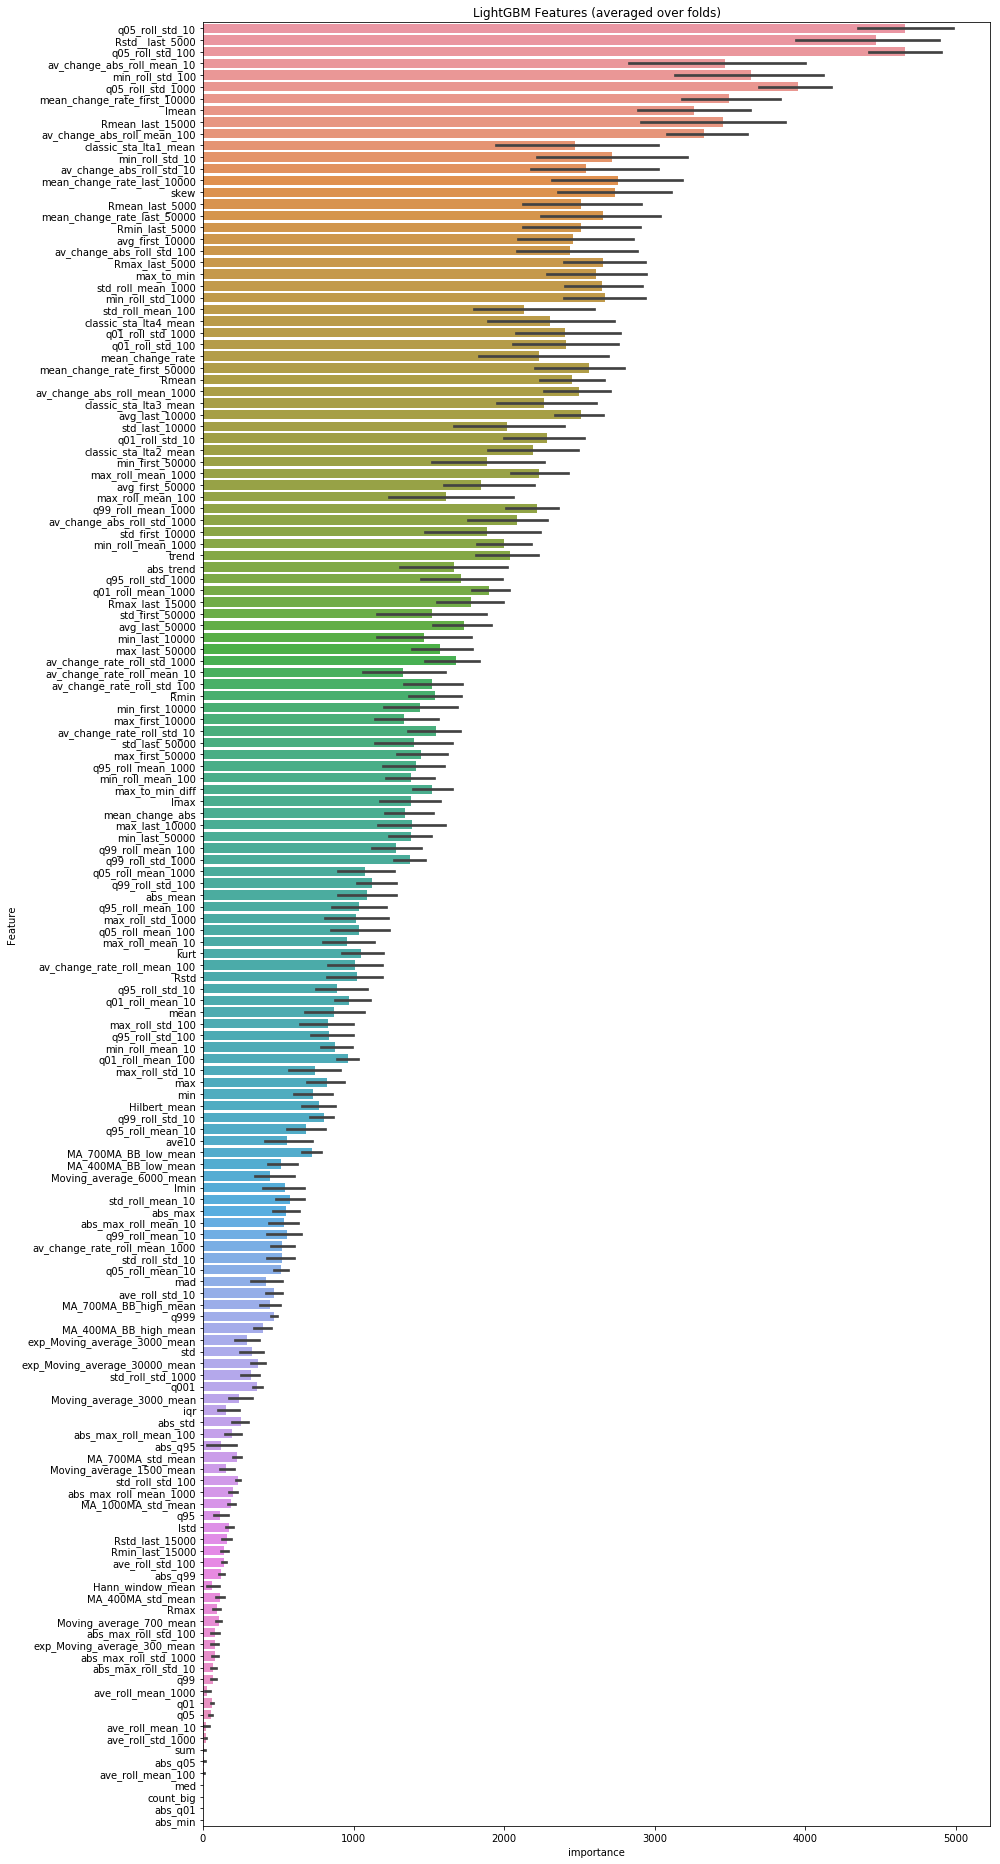

In [27]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# <a id='6'>Submission</a>  

We set the predicted time to failure in the submission file.

In [28]:
submission.time_to_failure = predictions
submission.to_csv('submission.csv',index=True)

# <a id='7'>References</a>  

[1] Fast Fourier Transform, https://en.wikipedia.org/wiki/Fast_Fourier_transform   
[2] Shifting aperture, in Neural network for inverse mapping in eddy current testing, https://www.researchgate.net/publication/3839126_Neural_network_for_inverse_mapping_in_eddy_current_testing   
[3] Andrews Script plus a Genetic Program Model, https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model/